In [2]:
using Pkg
Pkg.add("Images")
Pkg.add("DSP")
Pkg.add("FFTW")
Pkg.add("TestImages")
Pkg.add("ImageIO")
Pkg.add("FileIO")
Pkg.add("ImageMagick")
Pkg.add("Plots")
Pkg.add("Printf")

   Resolving package versions...
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\letha\.julia\environments\v1.7\Project.toml`
  No Changes to 

In [3]:
using LinearAlgebra
using Plots
using DSP
using FFTW
using Test
using TestImages
using ImageIO
using FileIO
using ImageMagick
using Images
using Printf

# Intro to Convolution

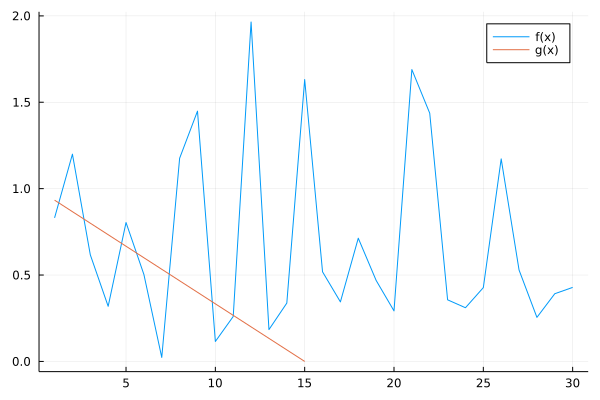

In [4]:
N = 30;
idx = 1:N
M = 15;
g_fun = (x) -> -x + M; 
g = g_fun.(1:M) ./ 15
f = abs.(randn(1,N)')
plot(f, label="f(x)")
plot!(g, label="g(x)")

$$ y(n) = \sum_{-\infty}^{\infty} f(i)\cdot g(n-i) $$

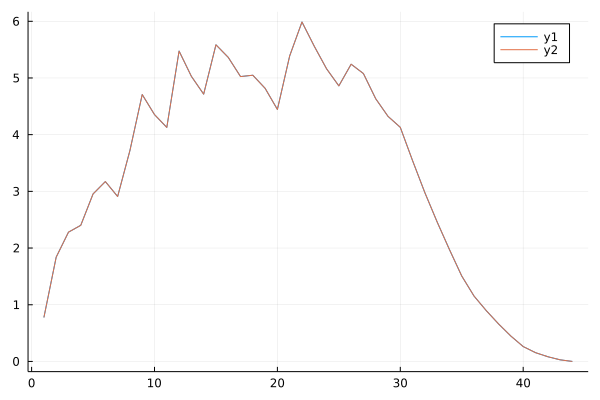

In [5]:
function ConvolutionImp(f, g, offset=nothing)
    N = length(f);
    M = length(g);

    if isnothing(offset)
        offset = -M
    end

    f = [f; zeros(M)]

    g = [g; zeros(N)]

    R = zeros(N+M-1)
    for i in 1:N+M-1
        for t in offset:M+offset
            if t + i > 0 && -t + 1 > 0
                R[i] =  R[i] + f[i+t]*g[-t+1];
            end
        end
    end
    R
end

R1 = ConvolutionImp(f,g)
R2 = DSP.conv(f, g)
plot(R1)
plot!(R2)

In [6]:
function Draw2dMat(m)
    heatmap(1:size(m,2),
        1:size(m,1), m,
        c=cgrad([:black, :white]))
end

Draw2dMat (generic function with 1 method)

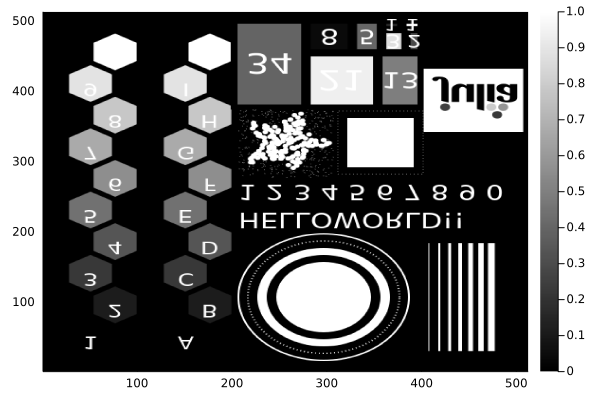

In [7]:
SizeN = 50;
f = abs.(rand(SizeN, SizeN))
img = testimage("morphology_test_512")
f = channelview(img)[1, :, :]
Sizex, Sizey = size(f)
Draw2dMat(f)

g = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


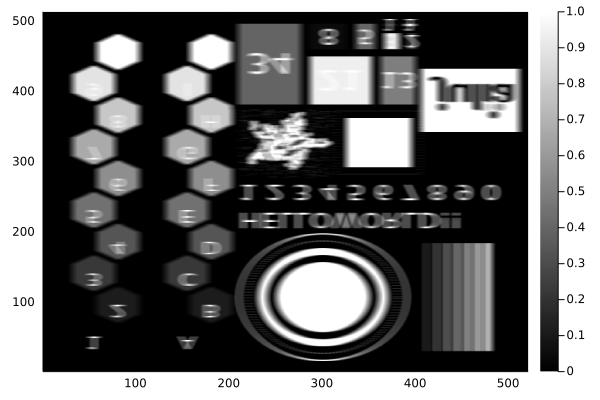

In [8]:
g = ones(10);
g = normalize(g,1)
@show g
N = length(g);
R = zeros(Sizex, Sizey + N - 1)
for i in 1:Sizey
    R[i, :] = ConvolutionImp(f[i, :], g)
end

Draw2dMat(R)

In [9]:
function Convolution2D(f, g, offset=nothing)

    nx, ny = size(f)
    mx, my = size(g)

    if isnothing(offset)
        offset = [-mx, -my]
    end
    
    f = [f zeros(nx, my)]
    f = [f; zeros(mx, ny+my)]
    
    g = [g zeros(mx, ny)]
    g = [g; zeros(nx, my+ny)]
    
    
    R = zeros(nx+mx-1, ny+my-1)
    
    for x in 1:nx+mx-1, y in 1:ny+my-1
        for tx in offset[1]:mx+offset[1], ty in offset[2]:mx+offset[2]
            if tx + x > 0 && -tx + 1 > 0 && ty + y > 0 && -ty + 1 > 0
                R[x, y] =  R[x, y] + f[tx + x, ty + y]*g[-tx + 1, -ty + 1];
            end
        end
    end
    R
end

Convolution2D (generic function with 2 methods)

g = [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


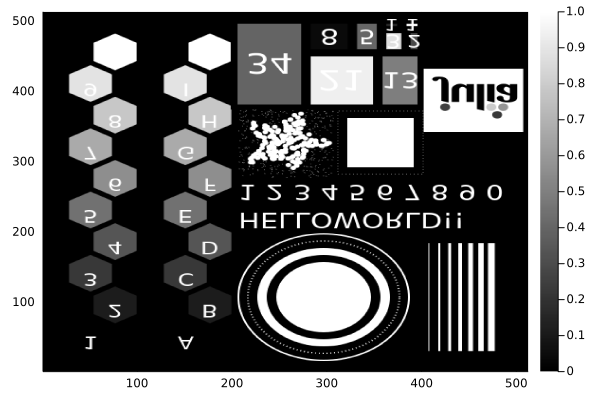

In [10]:
g = ones(10, 10)
g = normalize(g, 1)

@show g

#f = abs.(rand(30, 30))
Draw2dMat(f)

In [11]:
g = [-1 -1 -1; 2 2 2; -1 -1 -1]
g = [-1 2 -1; -1 2 -1; -1 2 -1]
#g = normalize(g, 1)

3×3 Matrix{Int64}:
 -1  2  -1
 -1  2  -1
 -1  2  -1

In [12]:
function Convolution2D_FFT(f,g)
    nx, ny = size(f)
    mx, my = size(g)
    
    f = [f zeros(nx, my)]
    f = [f; zeros(mx, ny+my)]
    
    g = [g zeros(mx, ny)]
    g = [g; zeros(nx, my+ny)]    

    return real(ifft(fft(f).*fft(g)))
end

Convolution2D_FFT (generic function with 1 method)

In [13]:
function DFT(A)
    
    M,N = size(A)
    
    out = convert(Array{ComplexF64},zeros(M,N))
    
    SumI = 0
    SumO = 0
    
    for u in 1:(M-1)
        for v in 1:(N-1)
            for x in 1:(M-1)
                for y in 1:(N-1)
                    SumI += A[x,y]*exp(-pi*((u*x/M)+(v*y/N))im)
                end
                SumO += SumI
            end
            
            out[u,v] = SumO
            SumO = 0;
            SumI = 0;
                
        end
    end
    
    return out
end

DFT (generic function with 1 method)

In [14]:
function Convolution2D_DFT(f,g)
    nx, ny = size(f)
    mx, my = size(g)
    
    f = [f zeros(nx, my)]
    f = [f; zeros(mx, ny+my)]
    
    g = [g zeros(mx, ny)]
    g = [g; zeros(nx, my+ny)]    

    return real(ifft(fft(f).*DFT(g)))
end

Convolution2D_DFT (generic function with 1 method)

In [ ]:
#DFT(g)
R = Convolution2D_DFT(f,g)
R[R.<0] .= 0
R[R.>1] .= 1
Draw2dMat(R)

In [ ]:
R = Convolution2D(f, g)
R[R.<0] .= 0
R[R.>1] .= 1
Draw2dMat(R)

In [ ]:
R = Convolution2D_FFT(f, g)
R[R.<0] .= 0
R[R.>1] .= 1
Draw2dMat(R)

# Time Complexity

In [ ]:
f = abs.(rand(30, 300))

CspendTime = [];
FspendTime = [];
DspendTime = [];

RunningTimes = 10;

for i in 1:30
    g = ones(i,i)
    g = normalize(g, 1)

    start = time()
    for j in 1:RunningTimes
        Convolution2D_FFT(f, g);
    end
    push!(FspendTime, (time()-start)/RunningTimes)

    start = time()
    for j in 1:RunningTimes
        Convolution2D(f, g);
    end
    push!(CspendTime, (time()-start)/RunningTimes)

    start = time()
    for j in 1:RunningTimes
        DSP.conv(f,g);
    end
    push!(DspendTime, (time()-start)/RunningTimes)
end

plot(CspendTime, label="Traditional Convolution", xlabel="n", ylabel="Time(sec)")
plot!(FspendTime, label="Convolution With FFT")
plot!(DspendTime, label="DSP.conv()")

In [ ]:
m = 30
n = 1:30
m2 = m^2
n2 = n.^2

plot(m2.*n2+n2.^2, yscale=:log10, label="Traditional Convolution", xlabel="n", ylabel="O()")
plot!(3*(m2.+n2).*(log.(m2.+n2)).+(m2.+n2), label="Convolution With FFT")

Complexity For Traditional Convolution
$$
O(mn+n^2)
$$
Complexity For Convolution With FFT
$$
O((m+n)(\log(m+n)+1))
$$